# Chapter 05: Hierarchical Modeling with Partial Pooling

This notebook demonstrates one of vangja's most powerful features: **hierarchical Bayesian modeling** with partial pooling. This is inspired by:

- The [timeseers](https://github.com/MBrouns/timeseers) library, which extends Facebook Prophet with hierarchical modeling capabilities
- Matthijs Brouns' **PyMCon 2020** talk: [*Forecasting Hierarchical Time Series*](https://www.youtube.com/watch?v=appLxcMLT9Y)
- Matthijs Brouns' **PyData** talk: [*Hierarchical Time Series Forecasting*](https://www.youtube.com/watch?v=jo12CWZ00Lo)

## Why Hierarchical Modeling?

When forecasting multiple related time series, we often face a trade-off:

1. **Complete pooling** (`pool_type="complete"`): All series share the same parameters. This is useful when series are very similar, but ignores individual differences.

2. **No pooling** (`pool_type="individual"`): Each series has independent parameters. This captures individual differences, but doesn't leverage shared patterns and can overfit with limited data.

3. **Partial pooling** (`pool_type="partial"`): Parameters are drawn from a shared distribution (hyperprior). This allows series to "borrow strength" from each other while still capturing individual differences.

**Partial pooling is especially valuable when:**
- Some series have limited data
- Series belong to natural groups (e.g., stores in regions, products in categories)
- You want to share seasonal patterns while allowing different trends

## Key Parameters for Pooling

In vangja, hierarchical modeling uses several pooling-related parameters:

- **`pool_type`**: Controls pooling for the main parameters (slope, intercept, Fourier coefficients)

- **`delta_pool_type`**: Controls pooling specifically for changepoint deltas (slope changes). In most cases, use `"individual"` even when `pool_type="partial"`, because changepoint timing and magnitude are typically series-specific. Use `"partial"` only when you believe series share similar trend change patterns (e.g., products affected by the same market events).

- **`sigma_pool_type`**: Controls pooling for the observation noise (sigma). Use `"individual"` when series have different noise levels, which is almost always the case. Use `"partial"` or `"complete"` only when series are measured with the same instrument/process and expected to have identical noise characteristics.

- **`shrinkage_strength`**: Controls how strongly series are pulled toward the shared mean. Higher values = more pooling.

## In This Notebook

We'll generate synthetic data representing multiple "product" time series that belong to two seasonal groups ("summer" and "winter" products), then compare:
- Individual fitting (no pooling)
- Partial pooling within groups
- Complete pooling across all series

## Setup and Imports

In [1]:
import warnings

warnings.filterwarnings("ignore")

In [2]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from vangja import LinearTrend, FourierSeasonality
from vangja.datasets import generate_hierarchical_products
from vangja.utils import metrics

# Set random seed for reproducibility
np.random.seed(42)

print("Imports successful!")

Imports successful!


## Data Generation

We'll use synthetic time series data representing sales for different products, inspired by the [timeseers](https://github.com/MBrouns/timeseers) library. The key insight is that products within the same "group" share similar seasonal patterns:

- **Summer products** (3 series): Peak in summer months (positive yearly seasonality)
- **Winter products** (2 series): Peak in winter months (opposite yearly seasonality)
- **All-year products** (1 series): Minimal yearly seasonality

This scenario is ideal for hierarchical modeling: products within a group share seasonal patterns, but each product has its own trend and noise level.

**Note**: The generated data contains random gaps (missing time intervals) for each product except `all_year`. This simulates real-world scenarios where data collection may be interrupted. We use scatter plots instead of line plots to properly visualize the data without connecting points across gaps.

In [3]:
# Generate hierarchical product data with all 6 series (including all_year)
df, product_params = generate_hierarchical_products(seed=42, include_all_year=True)

print(f"Date range: {df['ds'].min().date()} to {df['ds'].max().date()}")
print(f"Number of products: {len(product_params)}")
print(
    f"Summer products: {[k for k, v in product_params.items() if v['group'] == 'summer']}"
)
print(
    f"Winter products: {[k for k, v in product_params.items() if v['group'] == 'winter']}"
)
print(
    f"All-year products: {[k for k, v in product_params.items() if v['group'] == 'all_year']}"
)

Date range: 2018-01-01 to 2020-12-31
Number of products: 6
Summer products: ['summer_1', 'summer_2', 'summer_3']
Winter products: ['winter_1', 'winter_2']
All-year products: ['all_year']


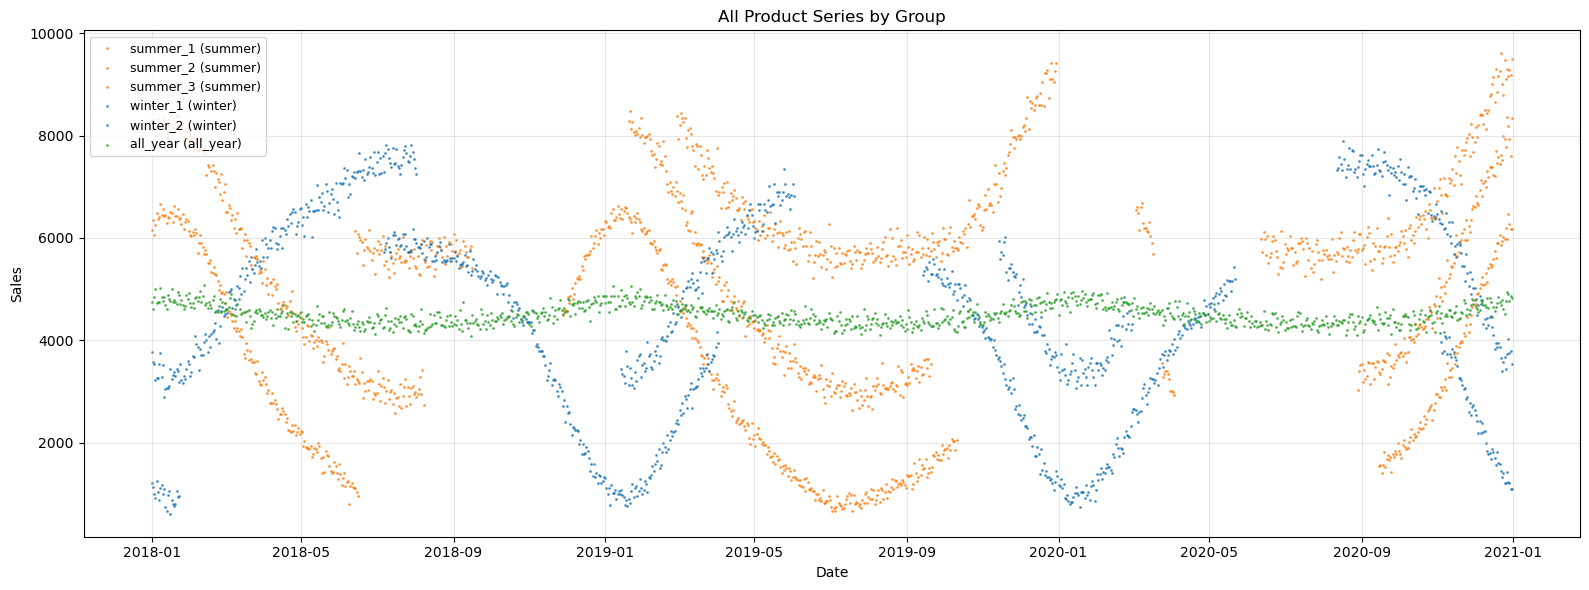

summer_1: y range = [2572, 8535], n_points = 604
summer_2: y range = [664, 6658], n_points = 604
summer_3: y range = [5205, 9608], n_points = 604
winter_1: y range = [609, 6172], n_points = 604
winter_2: y range = [2896, 7888], n_points = 604
all_year: y range = [4091, 5072], n_points = 1096


In [4]:
# Visualize all series in a single plot with colors by group
# Using scatter plot to handle gaps in data (missing intervals)
fig, ax = plt.subplots(figsize=(16, 6))

# Define colors by group
group_colors = {"summer": "tab:orange", "winter": "tab:blue", "all_year": "tab:green"}

for name, params in product_params.items():
    series_data = df[df["series"] == name]
    color = group_colors[params["group"]]
    ax.scatter(
        series_data["ds"],
        series_data["y"],
        s=1,
        alpha=0.7,
        color=color,
        label=f"{name} ({params['group']})",
    )

ax.set_title("All Product Series by Group")
ax.set_xlabel("Date")
ax.set_ylabel("Sales")
ax.legend(loc="upper left", fontsize=9)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print y-ranges and data availability for each series
for name, params in product_params.items():
    series_data = df[df["series"] == name]
    print(
        f"{name}: y range = [{series_data['y'].min():.0f}, {series_data['y'].max():.0f}], "
        f"n_points = {len(series_data)}"
    )

---

## Approach 1: Individual Fitting (No Pooling)

First, let's fit each series independently using `pool_type="individual"`. Each series gets its own:
- Trend parameters (slope, intercept)
- Changepoint deltas (via `delta_pool_type="individual"`)
- Seasonality coefficients
- Observation noise (via `sigma_pool_type="individual"`)

Since each series is fit independently, the model can learn arbitrary seasonality patterns for each series.

**Why `delta_pool_type="individual"`?** Changepoints represent structural breaks in the trend—points where the growth rate changes. These are typically series-specific (e.g., a store renovation affects only that store's sales). Even with partial pooling on other parameters, keeping changepoint deltas individual allows each series to have its own trend dynamics.

**Why `sigma_pool_type="individual"`?** Each series may have different measurement noise, scale, or inherent variability. Using individual noise allows the model to properly weight the likelihood for each series.

In [5]:
# Create model with individual pooling (no information sharing)
# Each series gets its own parameters including observation noise
model_individual = (
    LinearTrend(n_changepoints=10, pool_type="individual", delta_pool_type="individual")
    + FourierSeasonality(period=365.25, series_order=5, pool_type="individual")
    + FourierSeasonality(period=7, series_order=2, pool_type="individual")
)

print(f"Model: {model_individual}")

Model: LT(n=10,r=0.8,tm=None) + FS(p=365.25,n=5,tm=None) + FS(p=7,n=2,tm=None)


In [6]:
# Fit the individual model with sigma_pool_type="individual"
# This allows each series to have its own observation noise level
start_time = time.time()
model_individual.fit(
    df, method="mapx", scale_mode="individual", sigma_pool_type="individual"
)
time_individual = time.time() - start_time

print(f"Individual fitting time: {time_individual:.2f}s")
print(f"Group mapping: {model_individual.groups_}")

Output()

Individual fitting time: 3.96s
Group mapping: {0: 'all_year', 1: 'summer_1', 2: 'summer_2', 3: 'summer_3', 4: 'winter_1', 5: 'winter_2'}


In [7]:
# Generate fitted values (predictions on training dates)
fitted_individual = model_individual.predict(horizon=0, freq="D")

# Calculate metrics for each series on the full dataset
individual_metrics = []
for name in product_params.keys():
    group_code = [k for k, v in model_individual.groups_.items() if v == name][0]
    series_data = df[df["series"] == name]
    fitted_for_metrics = fitted_individual[["ds", f"yhat_{group_code}"]].copy()
    fitted_for_metrics.columns = ["ds", "yhat_0"]
    m = metrics(series_data, fitted_for_metrics, "complete")
    m.index = [name]
    individual_metrics.append(m)

individual_metrics_df = pd.concat(individual_metrics)
print("Individual Fitting Metrics (in-sample):")
display(individual_metrics_df)

Individual Fitting Metrics (in-sample):


,mse,rmse,mae,mape
summer_1,23914.647068,154.643613,122.633038,0.028320
summer_2,10498.930066,102.464287,82.629160,0.037752
summer_3,38987.376059,197.452212,160.140251,0.025519
winter_1,14104.581893,118.762713,95.779489,0.043052
winter_2,30732.578658,175.307098,141.997764,0.028096
all_year,9672.444419,98.348586,78.091115,0.017374


---

## Approach 2: Partial Pooling (Hierarchical)

Now let's use partial pooling with `pool_type="partial"`. In this approach:

- **Trend**: Each series has its own slope and intercept, but they're drawn from a shared distribution. This allows series to "borrow strength" from each other.
- **Changepoint Deltas**: We keep `delta_pool_type="individual"` because trend breaks are typically series-specific.
- **Seasonality**: The Fourier coefficients are partially pooled, allowing series to share seasonal patterns while still having individual variations.

The hierarchical structure is:
```
slope_shared ~ Normal(0, σ_slope)
slope[i] ~ Normal(slope_shared, σ_individual)
```

This is the key advantage of vangja over Prophet: the ability to learn shared patterns across multiple time series while respecting individual differences.

**Why `delta_pool_type="individual"` even with partial pooling?** While we want to share information about the overall trend slope and seasonality patterns, the *timing and magnitude* of trend changepoints are usually series-specific. For example, a product launch affects one product's trend, not all products. Use `delta_pool_type="partial"` only when series are expected to have synchronized trend changes (e.g., all stores affected by the same economic event).

**Why `sigma_pool_type="individual"`?** Each product has different inherent variability due to its sales volume, customer base, etc. Sharing noise across series would underfit high-variance series and overfit low-variance ones.

In [8]:
# Create model with partial pooling (hierarchical)
model_partial = (
    LinearTrend(
        n_changepoints=10,
        pool_type="partial",
        delta_pool_type="partial",
        shrinkage_strength=10,
    )
    + FourierSeasonality(
        period=365.25, series_order=5, pool_type="partial", shrinkage_strength=10
    )
    + FourierSeasonality(
        period=7, series_order=2, pool_type="partial", shrinkage_strength=10
    )
)

print(f"Model: {model_partial}")

Model: LT(n=10,r=0.8,tm=None) + FS(p=365.25,n=5,tm=None) + FS(p=7,n=2,tm=None)


In [11]:
# Fit the partial pooling model
start_time = time.time()
model_partial.fit(
    df, method="mapx", scale_mode="individual", sigma_pool_type="individual"
)
time_partial = time.time() - start_time

print(f"Partial pooling fitting time: {time_partial:.2f}s")
print(f"Group mapping: {model_partial.groups_}")

Output()

Partial pooling fitting time: 9.22s
Group mapping: {0: 'all_year', 1: 'summer_1', 2: 'summer_2', 3: 'summer_3', 4: 'winter_1', 5: 'winter_2'}


In [12]:
# Generate predictions
future_partial = model_partial.predict(horizon=0, freq="D")

# Calculate metrics for each series
partial_metrics = []
for name in product_params.keys():
    group_code = [k for k, v in model_partial.groups_.items() if v == name][0]
    test_series = df[df["series"] == name]
    future_for_metrics = future_partial[["ds", f"yhat_{group_code}"]].copy()
    future_for_metrics.columns = ["ds", "yhat_0"]
    m = metrics(test_series, future_for_metrics, "complete")
    m.index = [name]
    partial_metrics.append(m)

partial_metrics_df = pd.concat(partial_metrics)
print("Partial Pooling Metrics:")
display(partial_metrics_df)

Partial Pooling Metrics:


,mse,rmse,mae,mape
summer_1,23927.910224,154.686490,122.700085,0.028337
summer_2,10499.485874,102.466999,82.596454,0.037739
summer_3,38993.546996,197.467838,160.153634,0.025522
winter_1,14142.250369,118.921194,95.946165,0.043173
winter_2,30733.611942,175.310045,141.993265,0.028094
all_year,9674.195810,98.357490,78.107096,0.017377


---

## Approach 3: Complete Pooling

For comparison, let's also try complete pooling where all series share the same parameters. This approach is rarely ideal for series with different trends or opposite seasonality patterns, but useful as a baseline.

Note: Complete pooling forces all series to share the same seasonality parameters, which is not ideal when series have opposite seasonal patterns.

In [13]:
# Create model with complete pooling (all series share parameters)
model_complete = (
    LinearTrend(n_changepoints=10, pool_type="complete", delta_pool_type="complete")
    + FourierSeasonality(period=365.25, series_order=5, pool_type="complete")
    + FourierSeasonality(period=7, series_order=2, pool_type="complete")
)

print(f"Model: {model_complete}")

Model: LT(n=10,r=0.8,tm=None) + FS(p=365.25,n=5,tm=None) + FS(p=7,n=2,tm=None)


In [14]:
# Fit the complete pooling model
start_time = time.time()
model_complete.fit(df, method="mapx")
time_complete = time.time() - start_time

print(f"Complete pooling fitting time: {time_complete:.2f}s")

Output()

Complete pooling fitting time: 2.47s


In [15]:
# Generate predictions
future_complete = model_complete.predict(horizon=0, freq="D")

# Calculate metrics for each series (same prediction for all)
complete_metrics = []
for name in product_params.keys():
    test_series = df[df["series"] == name]
    future_for_metrics = future_complete[["ds", "yhat_0"]].copy()
    m = metrics(test_series, future_for_metrics, "complete")
    m.index = [name]
    complete_metrics.append(m)

complete_metrics_df = pd.concat(complete_metrics)
print("Complete Pooling Metrics:")
display(complete_metrics_df)

Complete Pooling Metrics:


,mse,rmse,mae,mape
summer_1,2.787895e+06,1669.699119,1351.720968,0.278195
summer_2,5.009969e+06,2238.295958,2010.823770,1.176007
summer_3,4.365159e+06,2089.296326,1830.420622,0.271255
winter_1,4.394514e+06,2096.309619,1765.911841,1.069640
winter_2,2.652496e+06,1628.648406,1365.661964,0.238688
all_year,1.552502e+05,394.018072,316.244470,0.070136


---

## Comparison of Approaches

Let's compare all three approaches side by side.

In [16]:
# Create comparison table
comparison_rows = []

for name in product_params.keys():
    comparison_rows.append(
        {
            "Series": name,
            "Group": product_params[name]["group"],
            "Approach": "Individual",
            "RMSE": individual_metrics_df.loc[name, "rmse"],
            "MAE": individual_metrics_df.loc[name, "mae"],
            "MAPE": individual_metrics_df.loc[name, "mape"],
        }
    )
    comparison_rows.append(
        {
            "Series": name,
            "Group": product_params[name]["group"],
            "Approach": "Partial",
            "RMSE": partial_metrics_df.loc[name, "rmse"],
            "MAE": partial_metrics_df.loc[name, "mae"],
            "MAPE": partial_metrics_df.loc[name, "mape"],
        }
    )
    comparison_rows.append(
        {
            "Series": name,
            "Group": product_params[name]["group"],
            "Approach": "Complete",
            "RMSE": complete_metrics_df.loc[name, "rmse"],
            "MAE": complete_metrics_df.loc[name, "mae"],
            "MAPE": complete_metrics_df.loc[name, "mape"],
        }
    )

comparison_df = pd.DataFrame(comparison_rows)
print("Full Comparison:")
display(comparison_df)

Full Comparison:


,Series,Group,Approach,RMSE,MAE,MAPE
0,summer_1,summer,Individual,154.643613,122.633038,0.028320
1,summer_1,summer,Partial,154.686490,122.700085,0.028337
2,summer_1,summer,Complete,1669.699119,1351.720968,0.278195
3,summer_2,summer,Individual,102.464287,82.629160,0.037752
4,summer_2,summer,Partial,102.466999,82.596454,0.037739
5,summer_2,summer,Complete,2238.295958,2010.823770,1.176007
6,summer_3,summer,Individual,197.452212,160.140251,0.025519
7,summer_3,summer,Partial,197.467838,160.153634,0.025522
8,summer_3,summer,Complete,2089.296326,1830.420622,0.271255
9,winter_1,winter,Individual,118.762713,95.779489,0.043052


In [17]:
# Summary statistics by approach
summary = (
    comparison_df.groupby("Approach")
    .agg(
        {
            "RMSE": ["mean", "std"],
            "MAE": ["mean", "std"],
            "MAPE": ["mean", "std"],
        }
    )
    .round(2)
)

print("Summary Statistics by Approach:")
display(summary)

Summary Statistics by Approach:


RMSE              MAE          MAPE      
               mean     std     mean     std  mean   std
Approach                                                
Complete    1686.04  679.53  1440.13  610.02  0.52  0.48
Individual   141.16   40.86   113.55   33.44  0.03  0.01
Partial      141.20   40.85   113.58   33.43  0.03  0.01

In [18]:
# Timing comparison
timing_df = pd.DataFrame(
    {
        "Approach": ["Individual", "Partial", "Complete"],
        "Time (s)": [time_individual, time_partial, time_complete],
    }
)

print("Timing Comparison:")
display(timing_df)

Timing Comparison:


,Approach,Time (s)
0,Individual,3.961200
1,Partial,9.220521
2,Complete,2.468167


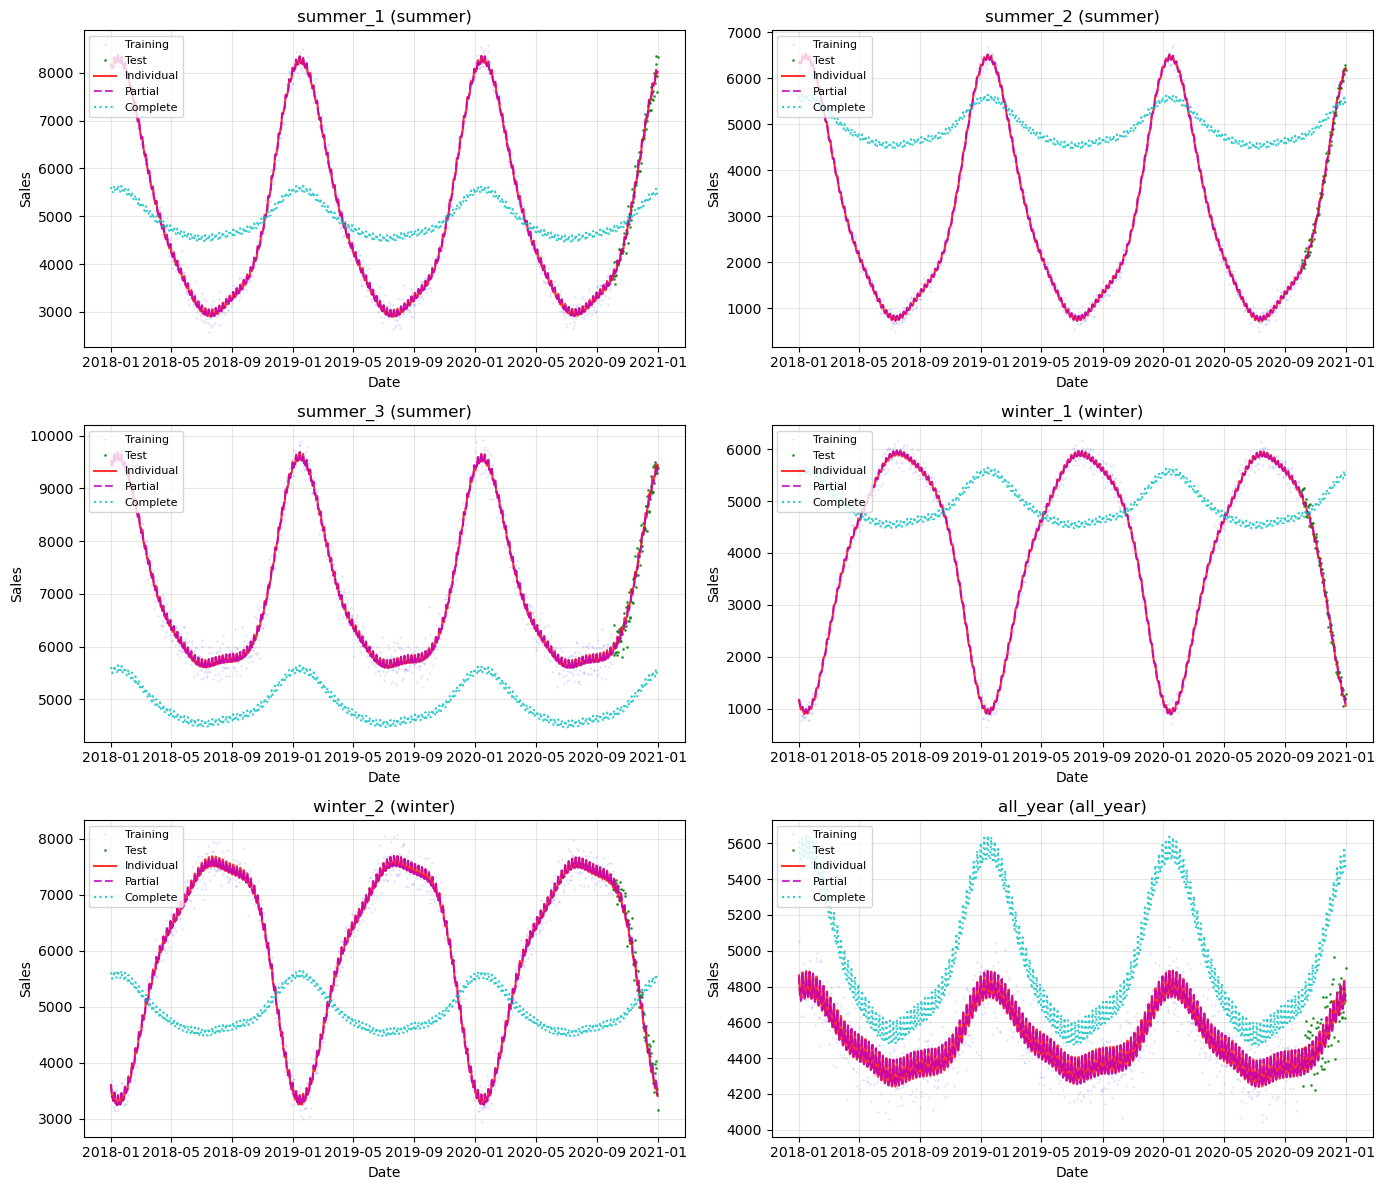

In [ ]:
# Visualize predictions for each series (2 per row for better readability)
fig, axes = plt.subplots(3, 2, figsize=(14, 12))
axes = axes.flatten()

for i, (name, params) in enumerate(product_params.items()):
    ax = axes[i]
    train_series = df[df["series"] == name]

    # Get predictions
    ind_group = [k for k, v in model_individual.groups_.items() if v == name][0]
    par_group = [k for k, v in model_partial.groups_.items() if v == name][0]

    # Plot training data
    ax.plot(
        train_series["ds"],
        train_series["y"],
        "b.",
        markersize=0.5,
        alpha=0.3,
        label="Training",
    )
    # Plot predictions
    ax.plot(
        future_individual["ds"],
        future_individual[f"yhat_{ind_group}"],
        "r-",
        linewidth=1.5,
        alpha=0.8,
        label="Individual",
    )
    ax.plot(
        future_partial["ds"],
        future_partial[f"yhat_{par_group}"],
        "m--",
        linewidth=1.5,
        alpha=0.8,
        label="Partial",
    )
    ax.plot(
        future_complete["ds"],
        future_complete["yhat_0"],
        "c:",
        linewidth=1.5,
        alpha=0.8,
        label="Complete",
    )

    ax.set_title(f"{name} ({params['group']})")
    ax.set_xlabel("Date")
    ax.set_ylabel("Sales")
    ax.legend(loc="upper left", fontsize=8)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Understanding Shrinkage Strength

The `shrinkage_strength` parameter controls how much the individual series are pulled toward the shared distribution:

- **High shrinkage** (e.g., 100): Series are pulled strongly toward the shared mean → closer to complete pooling
- **Low shrinkage** (e.g., 1): Series have more freedom to deviate → closer to individual fitting

Let's visualize this effect:

In [ ]:
shrinkage_values = [1, 10, 50, 100]
shrinkage_results = {}

for shrinkage in shrinkage_values:
    model = (
        LinearTrend(
            n_changepoints=10,
            pool_type="partial",
            delta_pool_type="partial",
            shrinkage_strength=shrinkage,
        )
        + FourierSeasonality(
            period=365.25,
            series_order=5,
            pool_type="partial",
            shrinkage_strength=shrinkage,
        )
        + FourierSeasonality(
            period=7, series_order=2, pool_type="partial", shrinkage_strength=shrinkage
        )
    )

    model.fit(train_df, method="mapx", scale_mode="individual")
    future = model.predict(horizon=test_days, freq="D")

    # Calculate average RMSE
    rmse_list = []
    for name in product_params.keys():
        group_code = [k for k, v in model.groups_.items() if v == name][0]
        test_series = test_df[test_df["series"] == name]
        future_for_metrics = future[["ds", f"yhat_{group_code}"]].copy()
        future_for_metrics.columns = ["ds", "yhat_0"]
        m = metrics(test_series, future_for_metrics, "complete")
        rmse_list.append(m["rmse"].values[0])

    shrinkage_results[shrinkage] = {
        "mean_rmse": np.mean(rmse_list),
        "std_rmse": np.std(rmse_list),
    }
    print(
        f"Shrinkage={shrinkage}: Mean RMSE = {np.mean(rmse_list):.2f} ± {np.std(rmse_list):.2f}"
    )

Output()

Shrinkage=1: Mean RMSE = 1674.87 ± 679.72


Output()

Shrinkage=10: Mean RMSE = 1679.81 ± 686.39


Output()

Shrinkage=50: Mean RMSE = 1686.22 ± 689.50


Output()

Shrinkage=100: Mean RMSE = 1675.44 ± 684.59


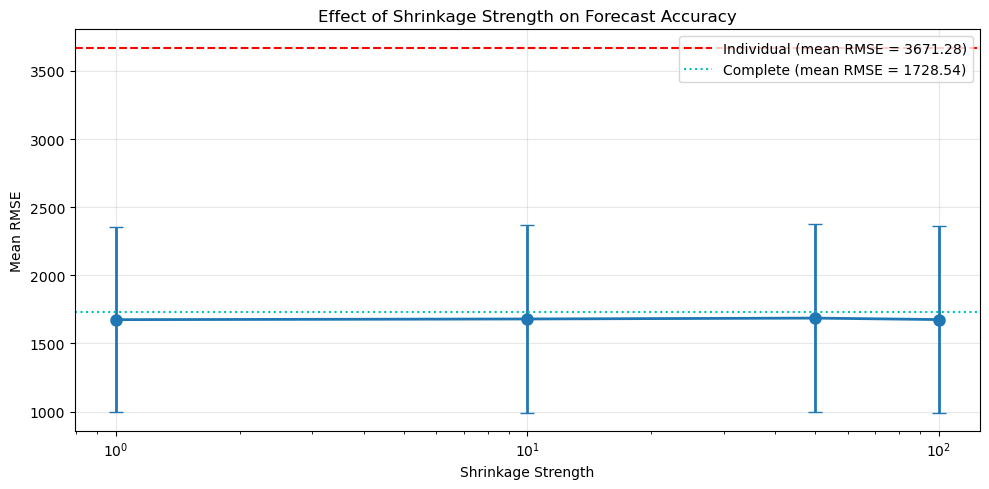

In [ ]:
# Plot shrinkage effect
fig, ax = plt.subplots(figsize=(10, 5))

shrinkages = list(shrinkage_results.keys())
mean_rmses = [shrinkage_results[s]["mean_rmse"] for s in shrinkages]
std_rmses = [shrinkage_results[s]["std_rmse"] for s in shrinkages]

ax.errorbar(
    shrinkages,
    mean_rmses,
    yerr=std_rmses,
    marker="o",
    capsize=5,
    linewidth=2,
    markersize=8,
)
ax.axhline(
    individual_metrics_df["rmse"].mean(),
    color="r",
    linestyle="--",
    label=f"Individual (mean RMSE = {individual_metrics_df['rmse'].mean():.2f})",
)
ax.axhline(
    complete_metrics_df["rmse"].mean(),
    color="c",
    linestyle=":",
    label=f"Complete (mean RMSE = {complete_metrics_df['rmse'].mean():.2f})",
)

ax.set_xlabel("Shrinkage Strength")
ax.set_ylabel("Mean RMSE")
ax.set_title("Effect of Shrinkage Strength on Forecast Accuracy")
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_xscale("log")

plt.tight_layout()
plt.show()

---

## Summary and Key Takeaways

### Pool Types in Vangja

| Pool Type | Description | Use Case |
|-----------|-------------|----------|
| `"complete"` | All series share parameters | Very similar series, single pattern to learn |
| `"individual"` | Each series has independent parameters | Unrelated series, sufficient data per series |
| `"partial"` | Hierarchical with shared hyperpriors | Related series, want to borrow strength |

### Key Pooling Parameters

| Parameter | Description |
|-----------|-------------|
| `pool_type` | Main pooling for trend/seasonality parameters |
| `delta_pool_type` | Pooling for changepoint deltas (use with `pool_type="partial"`) |
| `sigma_pool_type` | Pooling for observation noise (pass to `fit()`) |
| `shrinkage_strength` | How strongly series are pulled toward shared mean (higher = more pooling) |

### When to Use Partial Pooling

✅ **Use partial pooling when:**
- Series belong to natural groups (products, stores, regions)
- Some series have limited data
- You expect shared patterns across series
- You want to avoid overfitting on individual series

❌ **Avoid partial pooling when:**
- Series are truly independent with no shared patterns
- Each series has abundant data for reliable estimation
- Computational speed is critical (partial pooling adds complexity)

### Tuning Shrinkage Strength

- **Start with `shrinkage_strength=100`** as a reasonable default for strong pooling
- **Decrease** (e.g., 10-50) if series are quite different and need more flexibility
- **Increase** (e.g., 200+) if you want even more information sharing
- Use cross-validation to find the optimal value for your data